In [2]:
setwd("/projects/PPC/analysis/ppc_eqtls")

# Load libraries
source("scripts/packages.R"  )
source("scripts/input_data.R")
source("scripts/functions.R" )
source("scripts/3.4.coloc_adult/functions.R")

library(igraph)
packageVersion("igraph")
library(lsa)

set.seed(5366)
# suppressPackageStartupMessages(library(coloc))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”

Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




[1] ‘1.3.4’

Loading required package: SnowballC



## 0. Expressed genes

In [16]:
library(VennDiagram)

display_venn <- function(x, title, ...){
  library(VennDiagram)
  grid.newpage()
  venn_object <- venn.diagram(x, sub.cex = 1, filename = NULL, main = title, cat.cex = 2, label.cex = 2, cex = 2, main.cex = 3, ...)
  grid.draw(venn_object)
}

Loading required package: grid

Loading required package: futile.logger



[1] 20001

[1] 20001

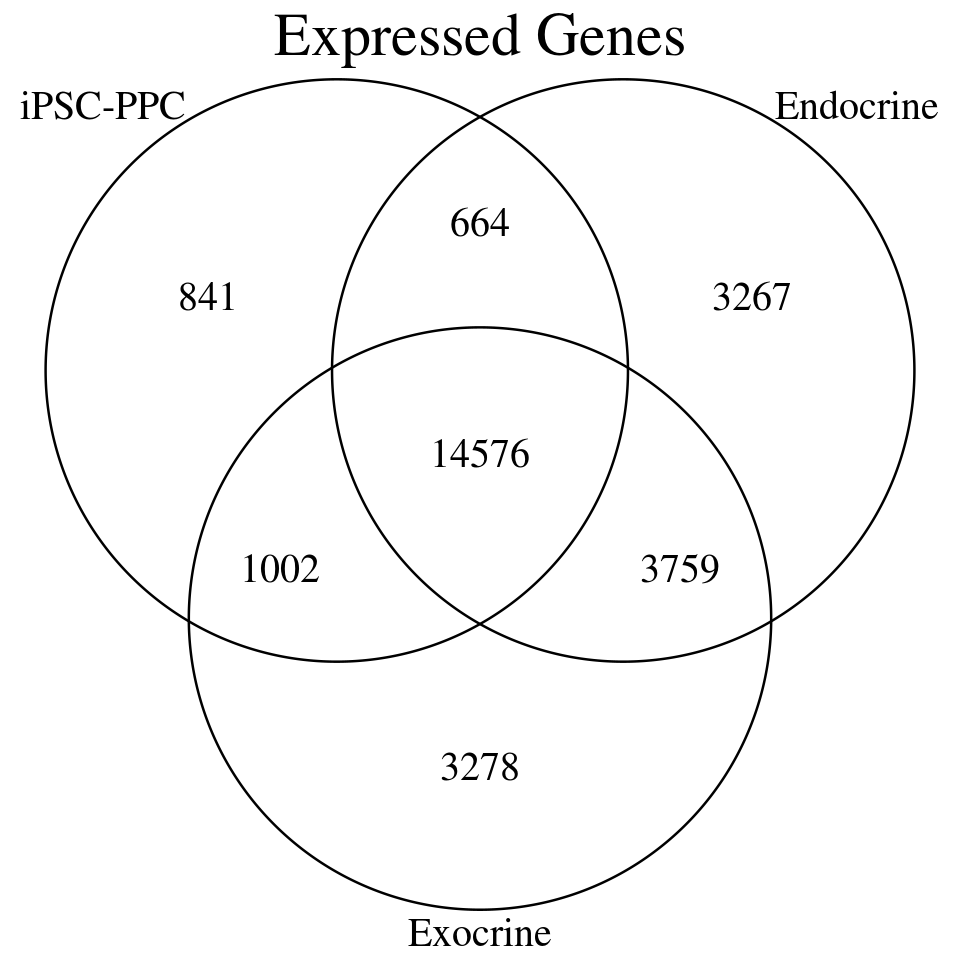

In [17]:
# genes
expressed_f = fread("pipeline/1.2.expression/gene_info.txt", data.table = F) %>% mutate(gene_id = simplify_id(gene_id)) %>% pull(gene_id)
expressed_i = simplify_id(readLines("input/eqtl/egene_lists/Islets_Gene_allIDs.txt") )
expressed_p = fread("input/eqtl/Pancreas.v8.egenes.txt.gz", data.table = F) %>% mutate(gene_id = simplify_id(gene_id)) %>% pull(gene_id)

psize(w = 8, h = 8)
display_venn(list("iPSC-PPC" = expressed_f, "Endocrine" = expressed_i, "Exocrine" = expressed_p), "Expressed Genes")

expressed_genes = c(intersect(expressed_f, expressed_i),
              intersect(expressed_f, expressed_p),
              intersect(expressed_i, expressed_p))

length(unique(expressed_genes))
664 + 14576 + 3759 + 1002

expressed = list("gene" = list("iPSC-PPC" = expressed_f, "Islets" = expressed_i, "Pancreas" = expressed_p, "All" = expressed_genes))

[1] 11402

[1] 11402

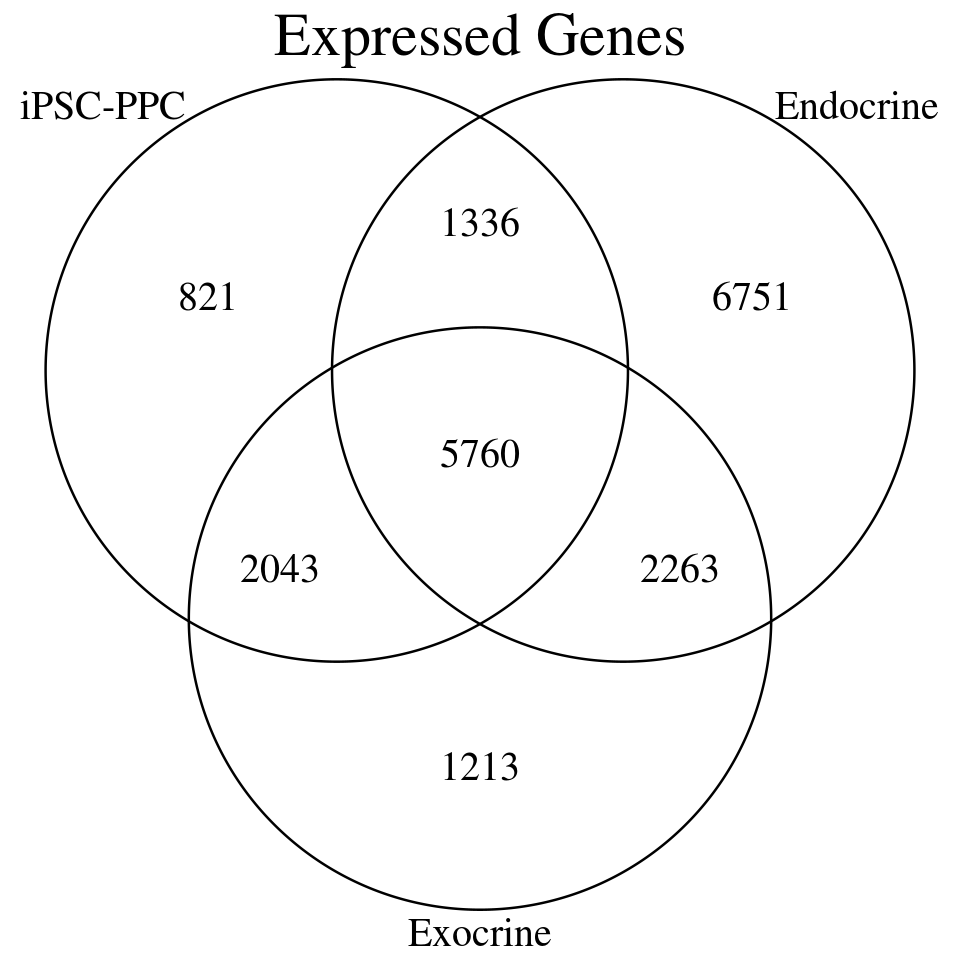

In [18]:
# isoforms
expressed_f = fread("pipeline/1.2.expression/isoform_info.txt", data.table = F) %>% mutate(gene_id = simplify_id(gene_id)) %>% pull(gene_id)
expressed_i = simplify_id(readLines("input/eqtl/egene_lists/Islets_Exons_allIDs.txt") )
expressed_p = fread("input/eqtl/Pancreas.v8.sgenes.txt.gz", data.table = F) %>% mutate(gene_id = simplify_id(gene_id)) %>% pull(gene_id)

psize(w = 8, h = 8)
display_venn(list("iPSC-PPC" = expressed_f, "Endocrine" = expressed_i, "Exocrine" = expressed_p), "Expressed Genes")

expressed_isoforms = c(intersect(expressed_f, expressed_i),
              intersect(expressed_f, expressed_p),
              intersect(expressed_i, expressed_p))

length(unique(expressed_isoforms))
1336 + 5760 + 2263 + 2043

expressed[["isoform"]] = list("iPSC-PPC" = expressed_f, "Islets" = expressed_i, "Pancreas" = expressed_p, "All" = expressed_isoforms)

In [19]:
names(expressed)

[1] "gene"    "isoform"

In [8]:
save(expressed, file = "pipeline/3.4.coloc_adult/summary/expressed_genes.ppc_endo_exo.robj")

## Keep eQTLs expressed in 2 of the 3 tissues

In [20]:
egene_filt = list()

In [299]:

# for (pheno in names(egene_list))
# {
#     for (tiss in names(egene_list[[pheno]]))
#     {
#         egene_filt[[pheno]][[tiss]] = egene_list[[pheno]][[tiss]] %>% filter(simplify_id(gene_id) %in% expressed[[pheno]]$All)
#         message(paste(pheno, tiss, length(unique(egene_filt[[pheno]][[tiss]]$qtl_id))))
#     }
# }

## Remove eQTLs with no CS

In [21]:
load("manuscript/robj/gt1_list.robj") 

In [22]:
for (pheno in names(egene_list))
{
    for (tiss in names(egene_list[[pheno]]))
    {
        a = gt1_list[[pheno]][[tiss]] %>% filter(SNP.PP >= 0.01)
        egene_filt[[pheno]][[tiss]] = egene_list[[pheno]][[tiss]] %>% filter(qtl_id %in% a$qtl_id)
        message(paste(pheno, tiss, length(unique(egene_filt[[pheno]][[tiss]]$qtl_id))))
    }
}

gene iPSC-PPC 4208

gene Islets 4086

gene Pancreas 8492

isoform iPSC-PPC 4028

isoform Islets 5092

isoform Pancreas 2127



## Remove eQTLs in MHC region

In [23]:
# remove MHC region
geneinfo = fread("/reference/private/Gencode.v34lift37/gene_info.txt", data.table = F) %>% mutate(transcript_id = gene_id)
isofinfo = fread("/reference/private/Gencode.v34lift37/isoform_info.txt", data.table = F) 

cols = c("chrom", "start", "end", "gene_id", "transcript_id", "gene_name")
geneinfo = rbind(geneinfo[,cols], isofinfo[,cols])

# chr6:29640168–33115544
fwrite(data.frame(chrom = "chr6", start = 29640168, end = 33115544), "mhc.bed", row.names = F, sep = "\t", col.names = F)
fwrite(geneinfo, "gene.bed", row.names = F, sep = "\t", col.names = F)

cmd = paste("bedtools intersect", "-a", "mhc.bed", "-b", "gene.bed", "-wa", "-wb", "-F 1")
gene_mhc = fread(cmd = cmd, data.table = F) %>% mutate(V8 = simplify_id(V8))

fwrite(gene_mhc, "pipeline/1.2.expression/genes_in_mhc.txt", row.names = F, sep = "\t", col.names = F)

head(gene_mhc, 2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,chr6,29640168,33115544,chr6,29640169,29648887,ENSG00000204644.9_4,ENSG00000204644,ZFP57
2,chr6,29640168,33115544,chr6,29640169,29644931,ENSG00000204644.9_4,ENST00000488757,ZFP57


In [24]:
for (pheno in names(egene_filt))
{
    for (tiss in names(egene_filt[[pheno]]))
    {
        egene_filt[[pheno]][[tiss]] = egene_filt[[pheno]][[tiss]] %>% filter(!simplify_id(gene_id) %in% gene_mhc$V8)
        message(paste(pheno, tiss, length(unique(egene_filt[[pheno]][[tiss]]$qtl_id))))
    }
}

gene iPSC-PPC 4149

gene Islets 4038

gene Pancreas 8408

isoform iPSC-PPC 3959

isoform Islets 5050

isoform Pancreas 2089



## Remove genes not in Gencode

In [25]:
gencode = fread("/reference/private/Gencode.v34lift37/gene_info.txt") %>% mutate(gene_id = simplify_id(gene_id))

In [26]:
for (pheno in names(egene_filt))
{
    for (tiss in names(egene_filt[[pheno]]))
    {
        egene_filt[[pheno]][[tiss]] = egene_filt[[pheno]][[tiss]] %>% filter(simplify_id(gene_id) %in% gencode$gene_id)
        message(paste(pheno, tiss, length(unique(egene_filt[[pheno]][[tiss]]$qtl_id))))
    }
}

gene iPSC-PPC 4149

gene Islets 3948

gene Pancreas 8312

isoform iPSC-PPC 3959

isoform Islets 4939

isoform Pancreas 2077



## 0. Coloc input 0.8

In [27]:
coloc_list = list()

In [28]:
# ppc-ppc
load("scripts/16.gene_isoform/summary/coloc.ppc_eqtls.gene_isoform.robj", verbose = T)
ppc_coloc = coloc_summary %>% 
    filter(type_id.1 %in% c(egene_filt[["gene"]][["iPSC-PPC"]]$qtl_id, egene_filt[["isoform"]][["iPSC-PPC"]]$qtl_id) &
           type_id.2 %in% c(egene_filt[["gene"]][["iPSC-PPC"]]$qtl_id, egene_filt[["isoform"]][["iPSC-PPC"]]$qtl_id) & 
           type_id.1 != type_id.2 & 
           transcript_id.1 != transcript_id.2) %>%
    filter(max_pp >= 0.8 & likely_hyp %like% "H4") %>%
    mutate(analysis.1 = ifelse(transcript_id.1 %like% "ENSG", "gene", "isoform")) %>%
    mutate(analysis.2 = ifelse(transcript_id.2 %like% "ENSG", "gene", "isoform")) %>%
    mutate(qtl_id.1 = type_id.1, qtl_id.2 = type_id.2, tiss.1 = "ppc", tiss.2 = "ppc") %>%
    select(qtl_id.1, qtl_id.2, nsnps, PP.H0.abf, PP.H1.abf, PP.H2.abf, PP.H3.abf, PP.H4.abf, tiss.1, tiss.2, analysis.1, analysis.2, topsnp, topsnp_pp)

table(ppc_coloc$analysis.1, ppc_coloc$analysis.2)

coloc_list[["ppc-ppc gene"]] = ppc_coloc %>% filter(analysis.1 == "gene" & analysis.2 == "gene")
coloc_list[["ppc-ppc isof"]] = ppc_coloc %>% filter(analysis.1 == "isoform" & analysis.2 == "isoform")

nrow(coloc_list[["ppc-ppc gene"]])
nrow(coloc_list[["ppc-ppc isof"]])

Loading objects:
  coloc_summary


         
          gene isoform
  gene     538    1074
  isoform 1074    2454

[1] 538

[1] 2454

In [29]:
# islet-islet
islet_coloc = fread("pipeline/3.4.coloc_adult/self_coloc/summary/islets_coloc.summary.txt", data.table = F) %>% 
    filter(PP.H4.abf >= 0.8 & 
           transcript_id.1 != transcript_id.2) %>%
    mutate(adult_id.1 = paste("Islets", transcript_id.1, sep = " ")) %>%
    mutate(adult_id.2 = paste("Islets", transcript_id.2, sep = " ")) %>% 
    filter(transcript_id.1 %in% gsub("Islets ", "", c(egene_filt[["gene"]][["Islets"]]$qtl_id, egene_filt[["isoform"]][["Islets"]]$qtl_id)) &
           transcript_id.2 %in% gsub("Islets ", "", c(egene_filt[["gene"]][["Islets"]]$qtl_id, egene_filt[["isoform"]][["Islets"]]$qtl_id))) %>%
    mutate(analysis.1 = ifelse(transcript_id.1 %in% gsub("Islets ", "", egene_filt[["gene"]][["Islets"]]$qtl_id), "gene", "isoform")) %>%
    mutate(analysis.2 = ifelse(transcript_id.2 %in% gsub("Islets ", "", egene_filt[["gene"]][["Islets"]]$qtl_id), "gene", "isoform")) %>%
    mutate(qtl_id.1 = adult_id.1, 
           qtl_id.2 = adult_id.2, 
           tiss.1 = "islet",
           tiss.2 = "islet") %>%
    mutate(topsnp = paste0("VAR_", topsnp)) %>%
    select(qtl_id.1, qtl_id.2, nsnps, PP.H0.abf, PP.H1.abf, PP.H2.abf, PP.H3.abf, PP.H4.abf, tiss.1, tiss.2, analysis.1, analysis.2, topsnp, topsnp_pp)

table(islet_coloc$analysis.1, islet_coloc$analysis.2)

coloc_list[["islet-islet gene"]] = islet_coloc %>% filter(analysis.1 == "gene" & analysis.2 == "gene")
coloc_list[["islet-islet isof"]] = islet_coloc %>% filter(analysis.1 == "isoform" & analysis.2 == "isoform")

nrow(coloc_list[["islet-islet gene"]])
nrow(coloc_list[["islet-islet isof"]])

         
          gene isoform
  gene     926    3588
  isoform 3588    1966

[1] 926

[1] 1966

In [30]:
# panc-panc
panc_coloc = fread(paste("pipeline/3.4.coloc_adult/summary", "Pancreas.coloc_summary.txt", sep = "/"), data.table = F) %>% 
        filter(PP.H4.abf >= 0.8 & 
               tiss.1 == "Pancreas" & 
               tiss.2 == "Pancreas") %>%
    mutate(qtl_id.1 = paste(tiss.1, transcript_id.1), 
           qtl_id.2 = paste(tiss.2, transcript_id.2), 
           tiss.1 = "pancreas", tiss.2 = "pancreas") %>%
    mutate(topsnp = paste0("VAR_", topsnp))

coloc_list[["panc-panc gene"]] = panc_coloc %>% filter(!transcript_id.1 %like% "clu" & !transcript_id.2 %like% "clu") %>%
    mutate(analysis.1 = "gene" , analysis.2 = "gene") %>%
    filter(qtl_id.1 %in% c(egene_filt[["gene"]][["Pancreas"]]$qtl_id, egene_filt[["isoform"]][["Pancreas"]])) %>%
    filter(qtl_id.2 %in% c(egene_filt[["gene"]][["Pancreas"]]$qtl_id, egene_filt[["isoform"]][["Pancreas"]])) %>%
    select(qtl_id.1, qtl_id.2, nsnps, PP.H0.abf, PP.H1.abf, PP.H2.abf, PP.H3.abf, PP.H4.abf, tiss.1, tiss.2, analysis.1, analysis.2, topsnp, topsnp_pp)

coloc_list[["panc-panc isof"]] = panc_coloc %>% filter(qtl_id.1 %like% "clu" | qtl_id.2 %like% "clu") 

nrow(coloc_list[["panc-panc gene"]])
nrow(coloc_list[["panc-panc isof"]])

files = list.files(paste("input/eqtl/eqtls_by_gene", paste("Pancreas", "v8_sQTL.hg19", sep = "."), sep = "/"))
a = as.data.frame(rbindlist(lapply(files, function(x) 
{ 
    g = simplify_id(unlist(strsplit(x, ":"))[5]) 
    t = gsub("Pancreas.v8_sQTL.hg19.", "", gsub(".txt", "", x))
    data.frame(transcript = t, gene_id = g)
})))

coloc_list[["panc-panc isof"]]$transcript_id.2 = suppressMessages(mapvalues(coloc_list[["panc-panc isof"]]$transcript_id.2, 
                                                                     a$gene_id, 
                                                                     a$transcript))

coloc_list[["panc-panc isof"]]$transcript_id.1 = suppressMessages(mapvalues(coloc_list[["panc-panc isof"]]$transcript_id.1, 
                                                                     a$gene_id, 
                                                                     a$transcript))

coloc_list[["panc-panc isof"]] = coloc_list[["panc-panc isof"]] %>% 
    mutate(qtl_id.1 = paste("Pancreas", transcript_id.1), 
           qtl_id.2 = paste("Pancreas", transcript_id.2)) %>%
    filter(qtl_id.1 %in% egene_filt[["isoform"]][["Pancreas"]]$qtl_id & 
           qtl_id.2 %in% egene_filt[["isoform"]][["Pancreas"]]$qtl_id) %>%
    mutate(analysis.1 = "isoform", analysis.2 = "isoform") %>%
    select(qtl_id.1, qtl_id.2, nsnps, PP.H0.abf, PP.H1.abf, PP.H2.abf, PP.H3.abf, PP.H4.abf, tiss.1, tiss.2, analysis.1, analysis.2, topsnp, topsnp_pp)
    
    
nrow(coloc_list[["panc-panc gene"]])
nrow(coloc_list[["panc-panc isof"]])

[1] 9524

[1] 2239

[1] 9524

[1] 2224

In [31]:
# islet-ppc
islet_ppc = fread("pipeline/3.4.coloc_adult/ppc_coloc/summary/ppc_coloc.summary_pp0.5.txt", data.table = F)  %>%
    filter(PP.H4.abf >= 0.8) %>%  
    mutate(adult_id = paste("Islets", adult.gene_id)) %>%
    mutate(qtl_id = paste(type, ppc.gene_id)) %>%
    filter(adult_id %in% c(egene_filt[["gene"]][["Islets"]]$qtl_id, egene_filt[["isoform"]][["Islets"]]$qtl_id)) %>%
    filter(qtl_id %in% c(egene_filt[["gene"]][["iPSC-PPC"]]$qtl_id, egene_filt[["isoform"]][["iPSC-PPC"]]$qtl_id)) %>%
    mutate(analysis.1 = ifelse(ppc.gene_id %like% "ENST", "isoform", "gene"),
           analysis.2 = ifelse(adult == "Islets_Exons", "isoform", "gene"),
           qtl_id.1 = qtl_id, qtl_id.2 = adult_id, tiss.1 = "ppc", tiss.2 = "islet") %>%
    select(qtl_id.1, qtl_id.2, nsnps, PP.H0.abf, PP.H1.abf, PP.H2.abf, PP.H3.abf, PP.H4.abf, tiss.1, tiss.2, analysis.1, analysis.2, topsnp, topsnp_pp)
    
table(islet_ppc$analysis.1, islet_ppc$analysis.2)

coloc_list[["islet-ppc gene"]] = islet_ppc %>% filter(analysis.1 == "gene" & analysis.2 == "gene")
coloc_list[["islet-ppc isof"]] = islet_ppc %>% filter(analysis.1 == "isoform" & analysis.2 == "isoform")

nrow(coloc_list[["islet-ppc gene"]])
nrow(coloc_list[["islet-ppc isof"]])

nrow(islet_ppc)

         
          gene isoform
  gene    1184       0
  isoform    0    1048

[1] 1184

[1] 1048

[1] 2232

In [32]:
# panc-ppc
panc_ppc = fread(paste("pipeline/3.4.coloc_adult/summary", "Pancreas.coloc_summary.txt", sep = "/"), data.table = F) %>% 
        filter(PP.H4.abf >= 0.8  &
               tiss.1 == "Pancreas" & tiss.2 == "PPC") %>%
    mutate(ppc.qtl_id = paste(ppc_qtl_type, simplify_id(transcript_id.2))) %>%
    filter(ppc.qtl_id %in% c(egene_filt[["gene"]][["iPSC-PPC"]]$qtl_id, egene_filt[["isoform"]][["iPSC-PPC"]]$qtl_id)) %>%
    mutate(qtl_id.1 = ppc.qtl_id, 
           qtl_id.2 = paste(tiss.1, transcript_id.1),
           tiss1 = "ppc", 
           tiss2 = "pancreas") %>%
    filter(qtl_id.2 %in% c(egene_filt[["gene"]][["Pancreas"]]$qtl_id, egene_filt[["isoform"]][["Pancreas"]]$qtl_id)) %>%
    mutate(topsnp = paste0("VAR_", topsnp)) %>%
    mutate(analysis.1 = ifelse(analysis == "gene", "gene", "isoform")) %>%
    mutate(analysis.2 = ifelse(analysis == "gene", "gene", "isoform")) %>% 
    select(qtl_id.1, qtl_id.2, nsnps, PP.H0.abf, PP.H1.abf, PP.H2.abf, PP.H3.abf, PP.H4.abf, tiss.1, tiss.2, analysis.1, analysis.2, topsnp, topsnp_pp)

table(panc_ppc$analysis.1, panc_ppc$analysis.2)

coloc_list[["panc-ppc gene"]] = panc_ppc %>% filter(analysis.1 == "gene")
coloc_list[["panc-ppc isof"]] = panc_ppc %>% filter(analysis.1 == "isoform")

nrow(coloc_list[["panc-ppc gene"]])
nrow(coloc_list[["panc-ppc isof"]])

         
          gene isoform
  gene    1876       0
  isoform    0     784

[1] 1876

[1] 784

In [33]:
# islet-panc
panc_islet = fread("pipeline/3.4.coloc_adult/summary/coloc_summary.pancreas_islets.txt", data.table = F) %>%
    filter(PP.H4.abf >= 0.8) %>%
    mutate(adult_id.1 = paste("Islets", transcript_id.1),
           adult_id.2 = paste("Pancreas", transcript_id.2),
           qtl_id.1 = adult_id.1, qtl_id.2 = adult_id.2, 
           tiss.1 = "islet", tiss.2 = "pancreas") %>%
    filter(qtl_id.1 %in% c(egene_filt[["gene"]][["Islets"]]$qtl_id, egene_filt[["gene"]][["Pancreas"]]$qtl_id, 
                           egene_filt[["isoform"]][["Islets"]]$qtl_id, egene_filt[["isoform"]][["Pancreas"]]$qtl_id),
           qtl_id.2 %in% c(egene_filt[["gene"]][["Islets"]]$qtl_id, egene_filt[["gene"]][["Pancreas"]]$qtl_id, 
                           egene_filt[["isoform"]][["Islets"]]$qtl_id, egene_filt[["isoform"]][["Pancreas"]]$qtl_id)) %>%
    mutate(analysis.1 = ifelse(analysis == "gene", "gene", "isoform"),
           analysis.2 = ifelse(analysis == "gene", "gene", "isoform")) %>%
    select(qtl_id.1, qtl_id.2, nsnps, PP.H0.abf, PP.H1.abf, PP.H2.abf, PP.H3.abf, PP.H4.abf, tiss.1, tiss.2, analysis.1, analysis.2, topsnp, topsnp_pp)

table(panc_islet$analysis.1, panc_islet$analysis.2)
head(panc_islet$topsnp)

coloc_list[["panc_islet gene"]] = panc_islet %>% filter(analysis.1 == "gene")
coloc_list[["panc_islet isof"]] = panc_islet %>% filter(analysis.1 == "isoform")

nrow(coloc_list[["panc_islet gene"]])
nrow(coloc_list[["panc_islet isof"]])

         
          gene isoform
  gene    2772       0
  isoform    0     858

[1] "VAR_6_46100032_G_A"  "VAR_17_46311075_G_A" "VAR_17_46207499_C_T"
[4] "VAR_7_150498508_G_T" "VAR_16_90085139_A_C" "VAR_16_90106364_C_A"

[1] 2772

[1] 858

In [34]:
for (name in names(coloc_list))
{
    message(name)
    print(head(coloc_list[[name]]$topsnp))
}

ppc-ppc gene



[1] "VAR_17_26686218_C_T" "VAR_7_102053414_C_A" "VAR_17_7184046_G_A" 
[4] "VAR_14_77315657_C_T" "VAR_14_77315657_C_T" "VAR_8_144623735_G_C"


ppc-ppc isof



[1] "VAR_12_9098995_G_GAAC" "VAR_12_9098995_G_GAAC" "VAR_1_24716529_C_A"   
[4] "VAR_17_48619272_G_A"   "VAR_7_75440271_A_T"    "VAR_16_620709_C_T"    


islet-islet gene



[1] "VAR_6_46100030_A_G"  "VAR_7_150498508_G_T" "VAR_2_37425629_A_G" 
[4] "VAR_2_75929130_C_A"  "VAR_7_95114704_T_C"  "VAR_17_26206414_C_A"


islet-islet isof



[1] "VAR_6_46114601_A_G"  "VAR_6_46100030_A_G"  "VAR_6_46114601_A_G" 
[4] "VAR_6_46100030_A_G"  "VAR_7_150498245_T_C" "VAR_7_150498508_G_T"


panc-panc gene



[1] "VAR_6_53380713_C_T"                               
[2] "VAR_6_41105476_T_TGAA"                            
[3] "VAR_1_24741819_A_G"                               
[4] "VAR_1_24708883_C_T"                               
[5] "VAR_12_1052488_A_G;12_1068184_T_C;12_1071302_AG_A"
[6] "VAR_17_37029069_C_T"                              


panc-panc isof



[1] "VAR_1_101530191_C_A;1_101532657_T_C;1_101543205_C_A;1_101546439_T_A"
[2] "VAR_1_104115017_C_A;1_104329823_C_A"                                
[3] "VAR_1_992840_ATT_A"                                                 
[4] "VAR_1_109472813_T_C"                                                
[5] "VAR_1_109727880_T_C"                                                
[6] "VAR_1_109765795_A_G"                                                


islet-ppc gene



[1] "VAR_16_90081660_A_G" "VAR_16_90103246_C_G" "VAR_17_26696482_C_T"
[4] "VAR_3_50174848_G_A"  "VAR_7_102053414_C_A" "VAR_2_75903170_A_G" 


islet-ppc isof



[1] "VAR_22_17630486_C_A"                                                                                                    
[2] "VAR_17_19495478_A_G"                                                                                                    
[3] "VAR_17_58156427_G_A;VAR_17_58157149_T_C;VAR_17_58167485_A_G;VAR_17_58168222_A_C;VAR_17_58168984_G_T;VAR_17_58172447_G_A"
[4] "VAR_22_51063477_T_C"                                                                                                    
[5] "VAR_16_31134213_T_A"                                                                                                    
[6] "VAR_8_109262752_G_A"                                                                                                    


panc-ppc gene



[1] "VAR_2_37517266_T_C"                                                                                                         
[2] "VAR_2_37518447_T_A"                                                                                                         
[3] "VAR_3_49986118_T_C;3_49989155_T_G;3_50008566_A_G;3_50022926_T_C;3_50025530_A_G;3_50026029_A_C;3_50035323_T_C;3_50039474_G_A"
[4] "VAR_19_2326902_G_A"                                                                                                         
[5] "VAR_6_82958246_A_G;6_82959192_C_G;6_82960309_A_G"                                                                           
[6] "VAR_11_3392098_C_G"                                                                                                         


panc-ppc isof



[1] "VAR_1_111728610_T_C"                                               
[2] "VAR_1_111728610_T_C"                                               
[3] "VAR_1_111728610_T_C"                                               
[4] "VAR_1_111728610_T_C"                                               
[5] "VAR_1_147129786_A_G"                                               
[6] "VAR_1_151752733_ATACTATCTATACAACCAGTCCTCAATTACTTTATATACAACCTCAGT_A"


panc_islet gene



[1] "VAR_6_46100032_G_A"  "VAR_17_46311075_G_A" "VAR_17_46207499_C_T"
[4] "VAR_7_150498508_G_T" "VAR_16_90085139_A_C" "VAR_16_90106364_C_A"


panc_islet isof



[1] "VAR_2_202015250_A_T" "VAR_2_242179134_G_A" "VAR_1_113083439_C_T"
[4] "VAR_1_113083439_C_T" "VAR_1_1627805_A_C"   "VAR_1_1627805_A_C"  


In [37]:
save(egene_filt, file = "pipeline/3.4.coloc_adult/summary/panc_islets.egene_filt.pp0.8.all_panc.gt1.robj")
save(coloc_list, file = "pipeline/3.4.coloc_adult/summary/panc_islets.actual_coloc_list.pp0.8.all_panc.gt1.robj")

In [218]:
for (name in names(coloc_list))
{
    message(paste(name, nrow(coloc_list[[name]])))
}

ppc-ppc gene 538

ppc-ppc isof 2454

islet-islet gene 926

islet-islet isof 1966

panc-panc gene 9524

panc-panc isof 2224

islet-ppc gene 1184

islet-ppc isof 1048

panc-ppc gene 1876

panc-ppc isof 784

panc_islet gene 2772

panc_islet isof 858



# 1a. Create networks (gene and isoform)

In [26]:
make_network = function(analysis, coloc_list, num_snps)
{
    tograph = as.data.frame(rbindlist(lapply(names(coloc_list), function(name)
    {
        if (name %like% analysis) { coloc_list[[name]] %>% select(qtl_id.1, qtl_id.2, tiss1, tiss2, PP.H4.abf, nsnps)}
    }))) %>% filter(nsnps >= num_snps)

    g = graph_from_data_frame(tograph, directed = F)
    c = cluster_louvain(g, weights = tograph$PP.H4.abf)
    return(list("graph" = g, "community" = c, "input" = tograph))
}

In [27]:
summarize_comm = function(analysis, c)
{
    geneinfo = fread("pipeline/1.2.expression/gene_isoform_info_notation.txt", data.table = F)
    out = as.data.frame(rbindlist(lapply(c(1:length(c)), function(id)
    {
        genes = c[[id]]
        ppc_ids = genes[which(!genes %like% "Islets" & !genes %like% "Pancreas")]
        islet_ids = genes[which(genes %like% "Islets")]
        panc_ids = genes[which(genes %like% "Pancreas")]

        if (analysis == "gene")
        {
            ppc_genes  = unlist(lapply(ppc_ids   , function(x) { unlist(strsplit(x, " "))[2] })) 
            islet_genes = unlist(lapply(islet_ids, function(x) { unlist(strsplit(x, " "))[2] }))
            panc_genes  = unlist(lapply(panc_ids , function(x) { unlist(strsplit(x, " "))[2] }))
        } else
        {
            ppc_genes = unlist(lapply(ppc_ids, function(x) { unlist(strsplit(x, " "))[2] }))
            islet_genes = unlist(lapply(islet_ids, function(x) { gsub("Islets ", "", unlist(strsplit(x, "[.]"))[1]) }))
            panc_genes = unlist(lapply(panc_ids, function(x) { simplify_id(unlist(strsplit(x, ":"))[5]) }))
        }

        data.frame(analysis              = analysis,
                   locus_id              = id,
                   signals               = paste(genes, collapse = ","),
                   number_signals        = length(unique(genes)),
                   number_ppc_signals    = length(unique(ppc_ids)),
                   number_islet_signals  = length(unique(islet_ids)),
                   number_panc_signals   = length(unique(panc_ids)),
                   number_genes          = length(unique(c(ppc_genes, islet_genes, panc_genes))),
                   number_ppc_genes      = length(unique(ppc_genes)),
                   number_islet_genes    = length(unique(islet_genes)),
                   number_panc_genes     = length(unique(panc_genes)),
                   same_genes.all        = length(unique(Reduce(intersect, list(ppc_genes,islet_genes,panc_genes)))),
                   same_genes.ppc_islet  = length(unique(Reduce(intersect, list(ppc_genes,islet_genes)))),
                   same_genes.ppc_panc   = length(unique(Reduce(intersect, list(ppc_genes,panc_genes)))),
                   diff_genes.ppc.islet_panc = length(unique(setdiff(ppc_genes, c(islet_genes, panc_genes)))),
                   diff_genes.islet_panc.ppc = length(unique(setdiff(c(islet_genes, panc_genes), ppc_genes))),
                   diff_genes.ppc.islet  = length(unique(setdiff(ppc_genes, islet_genes))),
                   diff_genes.islet.ppc  = length(unique(setdiff(islet_genes, ppc_genes))),
                   diff_genes.ppc.panc   = length(unique(setdiff(ppc_genes, panc_genes))),
                   diff_genes.panc.ppc   = length(unique(setdiff(panc_genes, ppc_genes)))
                  )
    })))

    return(out)
}

In [28]:
classify = function(summary)
{
    summary$islet_label = "NA"
    summary$islet_label = ifelse(summary$number_ppc_signals != 0 & summary$number_islet_signals != 0 & summary$same_genes.ppc_islet != 0 & summary$diff_genes.ppc.islet == 0 & summary$diff_genes.islet.ppc == 0, "same", summary$islet_label)
    summary$islet_label = ifelse(summary$number_ppc_signals != 0 & summary$number_islet_signals != 0 & summary$same_genes.ppc_islet == 0 & (summary$diff_genes.ppc.islet != 0 | summary$diff_genes.islet.ppc != 0), "diff", summary$islet_label)
    summary$islet_label = ifelse(summary$number_ppc_signals != 0 & summary$number_islet_signals != 0 & summary$same_genes.ppc_islet != 0 & (summary$diff_genes.ppc.islet != 0 | summary$diff_genes.islet.ppc != 0), "partial", summary$islet_label)
    summary$islet_label = ifelse(summary$number_ppc_signals != 0 & summary$number_islet_signals == 0 & summary$number_panc_signals == 0, "ppc-unique", summary$islet_label)
    summary$islet_label = ifelse(summary$number_ppc_signals != 0 & summary$number_islet_signals == 0 & summary$number_panc_signals != 0, "zero", summary$islet_label)
    summary$islet_label = ifelse(summary$number_ppc_signals == 0 & summary$number_islet_signals != 0 & summary$number_panc_signals == 0, "islet-unique", summary$islet_label)
    summary$islet_label = ifelse(summary$number_ppc_signals == 0 & summary$number_islet_signals == 0 & summary$number_panc_signals != 0, "panc-unique", summary$islet_label)
    summary$islet_label = ifelse(summary$number_ppc_signals == 0 & summary$number_islet_signals != 0 & summary$number_panc_signals != 0, "adult-unique", summary$islet_label)

    summary$panc_label = "NA"
    summary$panc_label = ifelse(summary$number_ppc_signals != 0 & summary$number_panc_signals != 0 & summary$same_genes.ppc_panc != 0 &  summary$diff_genes.ppc.panc == 0 & summary$diff_genes.panc.ppc == 0 , "same", summary$panc_label)
    summary$panc_label = ifelse(summary$number_ppc_signals != 0 & summary$number_panc_signals != 0 & summary$same_genes.ppc_panc == 0 & (summary$diff_genes.ppc.panc != 0 | summary$diff_genes.panc.ppc != 0), "diff", summary$panc_label)
    summary$panc_label = ifelse(summary$number_ppc_signals != 0 & summary$number_panc_signals != 0 & summary$same_genes.ppc_panc != 0 & (summary$diff_genes.ppc.panc != 0 | summary$diff_genes.panc.ppc != 0), "partial", summary$panc_label)
    summary$panc_label = ifelse(summary$number_ppc_signals != 0 & summary$number_islet_signals == 0 & summary$number_panc_signals == 0, "ppc-unique", summary$panc_label)
    summary$panc_label = ifelse(summary$number_ppc_signals != 0 & summary$number_panc_signals == 0 & summary$number_islet_signals != 0, "zero", summary$panc_label)
    summary$panc_label = ifelse(summary$number_ppc_signals == 0 & summary$number_panc_signals != 0 & summary$number_islet_signals == 0, "panc-unique", summary$panc_label)
    summary$panc_label = ifelse(summary$number_ppc_signals == 0 & summary$number_panc_signals == 0 & summary$number_islet_signals != 0, "islet-unique", summary$panc_label)
    summary$panc_label = ifelse(summary$number_ppc_signals == 0 & summary$number_panc_signals != 0 & summary$number_islet_signals != 0, "adult-unique", summary$panc_label)

    summary$final_class = ifelse(summary$islet_label == "ppc-unique"   & summary$panc_label == "ppc-unique"  , "ppc-unique", "NA")
    summary$final_class = ifelse(summary$islet_label == "islet-unique" & summary$panc_label == "islet-unique", "islet-unique", summary$final_class)
    summary$final_class = ifelse(summary$islet_label == "panc-unique"  & summary$panc_label == "panc-unique" , "panc-unique", summary$final_class)
    summary$final_class = ifelse(summary$islet_label == "adult-unique"  & summary$panc_label == "adult-unique", "adult-unique", summary$final_class)

    summary$final_class = ifelse(summary$final_class == "NA", paste(summary$islet_label, summary$panc_label), summary$final_class)

    return(summary)
}

In [29]:
plot_dist = function(analysis)
{
    toplot = data.frame(table(graphlist[[analysis]]$summary$final_class)) %>% mutate(Var1 = as.vector(Var1), Freq = as.numeric(Freq))
    toplot$islet = unlist(lapply(c(1:nrow(toplot)), function(row)
    {
        if (toplot[row,]$Var1 %like% "unique")
        {
            toplot[row,]$Var1
        } else
        {
            unlist(strsplit(toplot[row,]$Var1, " "))[1]
        }
    }))

    toplot$panc = unlist(lapply(c(1:nrow(toplot)), function(row)
    {
        if (toplot[row,]$Var1 %like% "unique")
        {
            toplot[row,]$Var1
        } else
        {
            unlist(strsplit(toplot[row,]$Var1, " "))[2]
        }
    }))

    order = c("ppc-unique", "islet-unique", "panc-unique", "adult-unique", "zero", "same", "partial", "diff")

    toplot$islet = factor(toplot$islet, levels = order)
    toplot$panc = factor(toplot$panc, levels = order)

    psize(w = 12, h = 9)
    ggplot(toplot, aes(x = islet, y = panc, fill = Freq, label = Freq)) + geom_tile(color = "black") + jn_theme + geom_text() + 
        scale_fill_gradientn(colors = c("#FFFAF1", "#EDDDB8", "#DCC080", "#CAA347", "#B8860E"), name = "# Modules") + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) + 
        ggtitle(analysis)
}

# plot signal function

In [30]:
plot_signal = function(sigs, analysis)
{
    qtl_data = as.data.frame(rbindlist(lapply(sigs, function(x)
    {
        
        gene = unlist(strsplit(x, " "))[2]
        
        if (analysis == "isof")
        {
            if (x %like% "Islets")
            {
                data = fread(paste("input/eqtl/eqtls_by_gene/Islets_Exons", paste("Islets_Exons", gene, "txt", sep = "."), sep = "/"), data.table = F) %>% select(pos, pval)
            } else if (x %like% "Pancreas")
            {
                data = fread(paste("input/eqtl/eqtls_by_gene/Pancreas.v8_sQTL.hg19", paste("Pancreas.v8_sQTL.hg19", gene, "txt", sep = "."), sep = "/"), data.table = F) %>% select(hg19_pos, pval) %>% rename(pos = hg19_pos)
            } else
            {
                qtltype = unlist(strsplit(x, " "))[1]
                files = list.files("pipeline/3.2.eqtls/eqtls_by_gene/ppc_eqtls_peer20.isoform", full.names = T)
                data = fread(files[which(files %like% "/qtl." & files %like% gene)], data.table = F) %>% filter(type == qtltype) 
                data = data %>% select(pos, pval) 
            }
        }
        
        if (analysis == "gene")
        {
            if (x %like% "Islets")
            {
                data = fread(paste("input/eqtl/eqtls_by_gene/Islets", paste("Islets", gene, "txt", sep = "."), sep = "/"), data.table = F) %>% select(pos, pval)
            } else if (x %like% "Pancreas")
            {
                data = fread(paste("input/eqtl/eqtls_by_gene/Pancreas.v8_eQTL.hg19", paste("Pancreas.v8_eQTL.hg19", gene, "txt", sep = "."), sep = "/"), data.table = F) %>% select(hg19_pos, pval) %>% rename(pos = hg19_pos)
            } else
            {
                qtltype = unlist(strsplit(x, " "))[1]
                files = list.files("pipeline/3.2.eqtls/eqtls_by_gene/ppc_eqtls_peer20.gene", full.names = T)
                data = fread(files[which(files %like% "/qtl." & files %like% gene)], data.table = F) %>% filter(type == qtltype) 
                data = data %>% select(pos, pval) 
            }
        }
        
        return(data %>% mutate(qtl_id = x) %>% mutate(lead = ifelse(pval == min(pval), T, F)))
    })))

    qtl_data$tiss = ifelse(qtl_data$qtl_id %like% "Islets", "Islets", ifelse(qtl_data$qtl_id %like% "Pancreas", "Pancreas", "PPC"))

    min.x = min(qtl_data[qtl_data$tiss == "PPC",]$pos)
    max.x = max(qtl_data[qtl_data$tiss == "PPC",]$pos)

    qtl_data2 = qtl_data %>% group_by(pos) %>% filter(pval == min(pval))

    qtl_data$gene_id = unlist(lapply(qtl_data$qtl_id, function(x) { unlist(strsplit(x, " "))[2] }))
    qtl_data$gene_name = suppressMessages(mapvalues(qtl_data$gene_id, geneinfo$gene_id, geneinfo$gene_name))
    qtl_data$qtl_id.name = paste(qtl_data$tiss, qtl_data$gene_name)
    qtl_data$qtl_id.name = ifelse(qtl_data$lead == T, qtl_data$qtl_id.name, NA)
    unique(qtl_data$qtl_id.name)

    psize(w = 12, h = 12)
    p0 = ggplot(qtl_data2 , aes(x = pos / 1e6, y = -log10(pval))) + 
        geom_point(size = 2, color = "#d1d0c8") + facet_wrap(~tiss, ncol = 1, scales = "free_y") +
        xlim(min.x / 1e6, max.x / 1e6) + jn_theme + theme(strip.text = element_text(size = 20)) + 
        geom_point(data = qtl_data[qtl_data$lead == T,], aes(x = pos/1e6, y = -log10(pval)), color = "red") +
        geom_vline(data = qtl_data[qtl_data$lead == T,], aes(xintercept = pos/1e6), linetype = "dashed", size = 0.8) + 
        scale_color_manual(values = colPanel) + 
        geom_text_repel(data = qtl_data %>% filter(lead == T), aes(x = pos/1e6, y = -log10(pval), label = qtl_id.name), color = "red") +
        guides(color = guide_legend(ncol = 1, override.aes = list(size = 3)))
    
    p1 = ggplot(qtl_data2, aes(x = pos / 1e6, y = -log10(pval), color = tiss)) + geom_point(size = 2) + facet_wrap(~qtl_id, ncol = 1) + jn_theme 
    
    return(list(p0, qtl_data))
}

# Adjust network function

    - if the parameters above are used on the entire genome, we would still be over-clustering
    - to fix this, do community detection on each chromosome separately
    - resolution 0-1 clustered the two loci together
    - resolution 2-3 separated the two loci
    - resolution 4+ separated the left locus into two even when their lead variants overlap

In [31]:
make_network = function(analysis, coloc_list, num_snps, chr, res)
{
    tograph = as.data.frame(rbindlist(lapply(names(coloc_list), function(name)
    {
        if (name %like% analysis) { coloc_list[[name]] %>% filter(topsnp %like% paste0("VAR_", chr, "_")) %>% 
                                   filter(qtl_id.1 != qtl_id.2) %>% 
                                   select(qtl_id.1, qtl_id.2, tiss.1, tiss.2, PP.H4.abf, nsnps)}
    }))) %>% filter(nsnps >= num_snps) 

    g = graph_from_data_frame(tograph, directed = F)
    c = cluster_leiden(g, objective_function = "modularity", n_iterations = 500, resolution = res)
    
    mod = modularity(g, c$membership)
    
    return(list("graph" = g, "community" = c, "input" = tograph, "modularity" = mod))
}

# Recall network

In [32]:
graphlist = list()
graphlist[["gene"]] = lapply(c(1:22), function(x) { make_network("gene", coloc_list, 500, x, 3) })
graphlist[["isof"]] = lapply(c(1:22), function(x) { make_network("isof", coloc_list, 500, x, 3) })

names(graphlist[["gene"]]) = paste0("chr", c(1:22))
names(graphlist[["isof"]]) = paste0("chr", c(1:22))

graphlist[["gene"]]$summary = as.data.frame(rbindlist(lapply(c(1:22), function(x) { summarize_comm("gene", graphlist[["gene"]][[paste0("chr", x)]]$community) %>% mutate(locus_id = paste(x, locus_id, sep = "_")) %>% rename(module_id = locus_id) })))
graphlist[["isof"]]$summary = as.data.frame(rbindlist(lapply(c(1:22), function(x) { summarize_comm("isof", graphlist[["isof"]][[paste0("chr", x)]]$community) %>% mutate(locus_id = paste(x, locus_id, sep = "_")) %>% rename(module_id = locus_id) })))

graphlist[["gene"]]$summary = classify(graphlist[["gene"]]$summary)
graphlist[["isof"]]$summary = classify(graphlist[["isof"]]$summary)


## Distribution of final classes

In [33]:
plot_dist = function(analysis)
{
    toplot = data.frame(table(graphlist[[analysis]]$summary$final_class)) %>% mutate(Var1 = as.vector(Var1), Freq = as.numeric(Freq))
    toplot$islet = unlist(lapply(c(1:nrow(toplot)), function(row)
    {
        if (toplot[row,]$Var1 %like% "unique")
        {
            toplot[row,]$Var1
        } else
        {
            unlist(strsplit(toplot[row,]$Var1, " "))[1]
        }
    }))

    toplot$panc = unlist(lapply(c(1:nrow(toplot)), function(row)
    {
        if (toplot[row,]$Var1 %like% "unique")
        {
            toplot[row,]$Var1
        } else
        {
            unlist(strsplit(toplot[row,]$Var1, " "))[2]
        }
    }))

    order = c("ppc-unique", "islet-unique", "panc-unique", "adult-unique", "zero", "same", "partial", "diff")

    toplot$islet = factor(toplot$islet, levels = order)
    toplot$panc = factor(toplot$panc, levels = order)

    psize(w = 12, h = 9)
    ggplot(toplot, aes(x = islet, y = panc, fill = Freq, label = Freq)) + geom_tile(color = "black") + jn_theme + geom_text() + 
        scale_fill_gradientn(colors = c("#FFFAF1", "#EDDDB8", "#DCC080", "#CAA347", "#B8860E"), name = "# Modules") + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) + 
        ggtitle(analysis)
}

In [34]:
a = graphlist[["isof"]]$summary
graphlist[["isof"]]$summary = as.data.frame(rbindlist(lapply(c(1:nrow(graphlist[["isof"]]$summary)), function(row)
{
    signals = unlist(strsplit(a[row,]$signals, ","))
    gene_list = list()
    for (s in signals)
    {
        if (s %like% "Pancreas")
        {
            gene_list[["Pancreas"]] = c(gene_list[["Pancreas"]], simplify_id(unlist(strsplit(s, ":"))[5]))
        } else if (s %like% "Islets")
        {
            gene_list[["Islets"]] = c(gene_list[["Islets"]], simplify_id(unlist(strsplit(s, " "))[2]))
        } else
        {
            gene_list[["iPSC-PPC"]] = simplify_id(geneinfo[geneinfo$transcript_id %like% unlist(strsplit(s, " "))[2],]$gene_id)
        }
    }

    out = data.frame(analysis = "isof", module_id = a[row,]$module_id, signals = a[row,]$signals)
    
    out$number_signals = length(signals)
    out$number_ppc_signals = length(signals[which(!signals %like% "Pancreas" & !signals %like% "Islets")])
    out$number_islet_signals = length(signals[which(signals %like% "Islets")])
    out$number_panc_signals = length(signals[which(signals %like% "Pancreas")])
    out$number_genes = length(unique(c(gene_list[["Pancreas"]], gene_list[["Islets"]], gene_list[["iPSC-PPC"]])))
    out$number_ppc_genes = length(unique(gene_list[["iPSC-PPC"]]))
    out$number_islet_genes = length(unique(gene_list[["Islets"]]))
    out$number_panc_genes = length(unique(gene_list[["Pancreas"]]))
    out$same_genes.all = length(intersect(gene_list[["Pancreas"]], intersect(gene_list[["Islets"]], gene_list[["iPSC-PPC"]])))
    out$same_genes.ppc_islet = length(intersect(gene_list[["iPSC-PPC"]], gene_list[["Islets"]]))
    out$same_genes.ppc_panc = length(intersect(gene_list[["iPSC-PPC"]], gene_list[["Pancreas"]]))
    out$diff_genes.ppc.islet_panc = length(setdiff(gene_list[["iPSC-PPC"]], c(gene_list[["Islets"]], gene_list[["Pancreas"]])))
    out$diff_genes.islet_panc.ppc = length(setdiff(c(gene_list[["Islets"]], gene_list[["Pancreas"]]), gene_list[["iPSC-PPC"]]))
    out$diff_genes.ppc.islet = length(setdiff(gene_list[["iPSC-PPC"]], gene_list[["Islets"]]))
    out$diff_genes.islet.ppc = length(setdiff(gene_list[["Islets"]], gene_list[["iPSC-PPC"]]))
    out$diff_genes.ppc.panc = length(setdiff(gene_list[["iPSC-PPC"]], gene_list[["Pancreas"]]))
    out$diff_genes.panc.ppc = length(setdiff(gene_list[["Pancreas"]], gene_list[["iPSC-PPC"]]))
    return(out)
})))

graphlist[["isof"]]$summary = classify(graphlist[["isof"]]$summary)

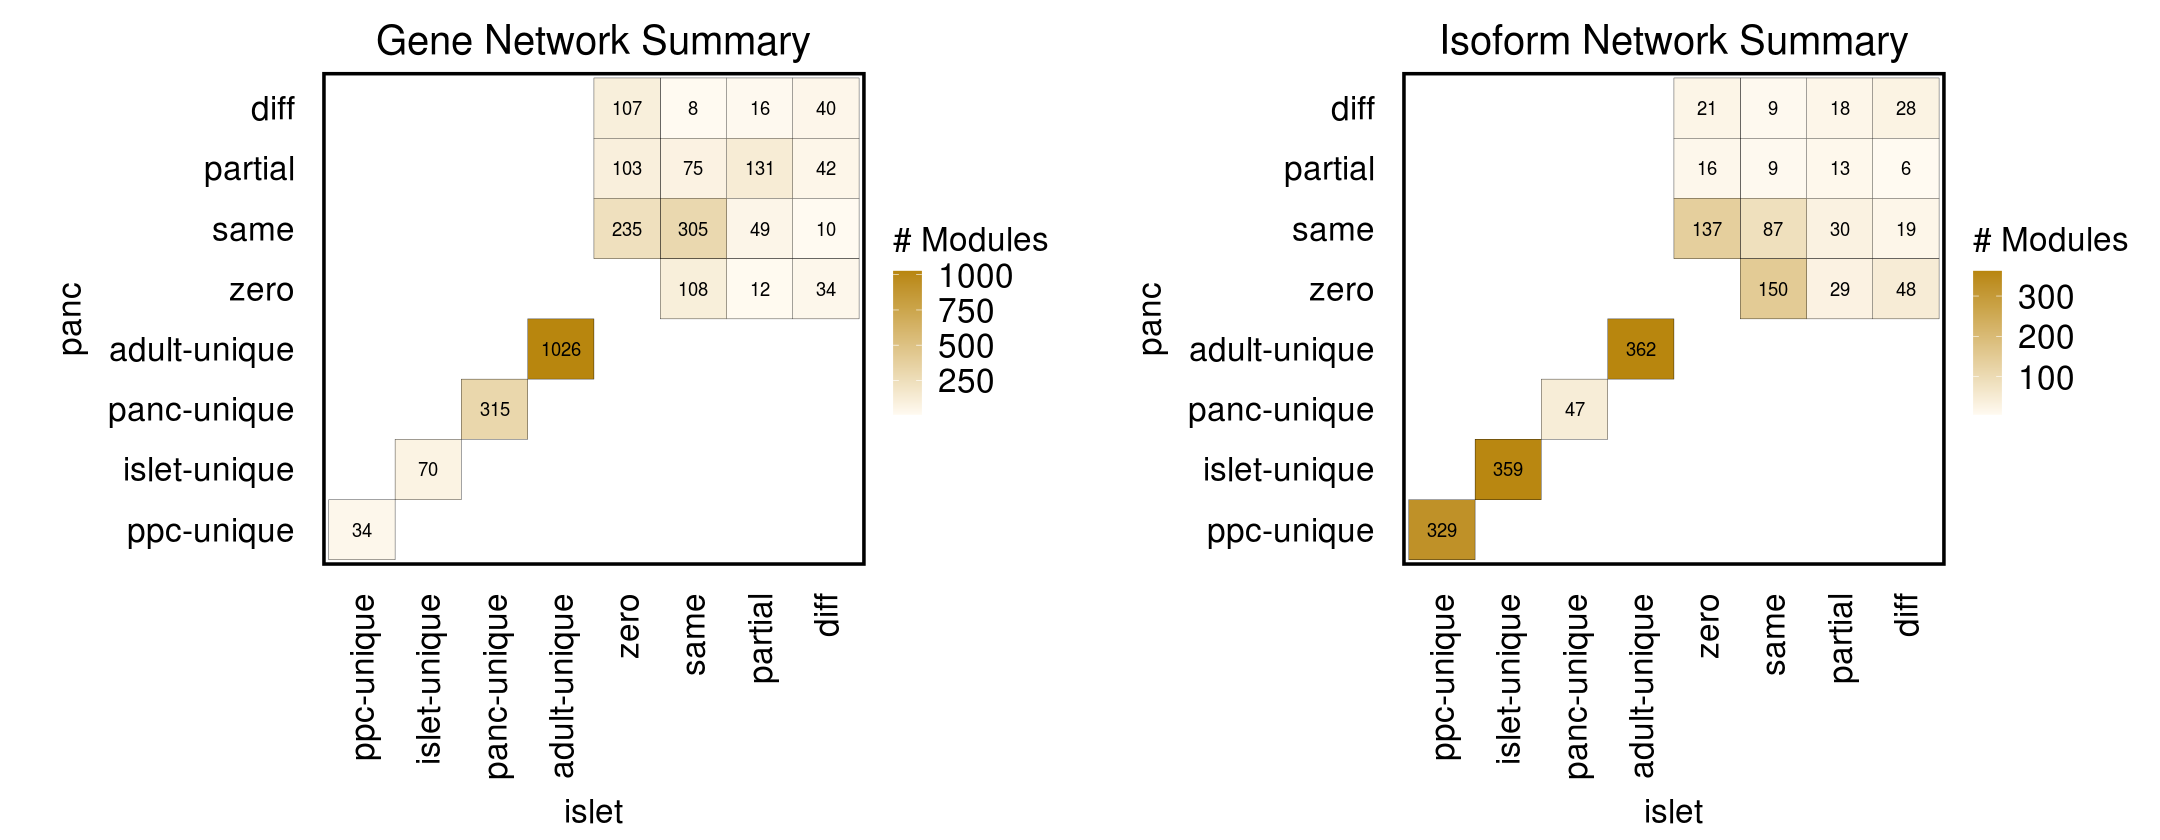

In [35]:
p0 = plot_dist("gene") + theme(plot.title = element_text(hjust = 0.5)) + ggtitle("Gene Network Summary") + theme(axis.ticks = element_blank())
p1 = plot_dist("isof") + theme(plot.title = element_text(hjust = 0.5)) + ggtitle("Isoform Network Summary") + theme(axis.ticks = element_blank())

psize(w = 18, h = 7)
plot_grid(p0, p1, nrow = 1)

## Check in GT1

In [36]:
input = as.data.frame(rbindlist(lapply(c(1:22), function(x) { graphlist[["gene"]][[paste0("chr", x)]]$input})))

a = c(input$qtl_id.1, input$qtl_id.2)
b = unlist(lapply(names(gt1_list[["gene"]]), function(x) { gt1_list[["gene"]][[x]]$qtl_id }))

message(paste("gene:", ifelse(length(a[which(!a %in% b)]) != 0, T, F)))

input = as.data.frame(rbindlist(lapply(c(1:22), function(x) { graphlist[["isoform"]][[paste0("chr", x)]]$input})))

a = c(input$qtl_id.1, input$qtl_id.2)
b = unlist(lapply(names(gt1_list[["isoform"]]), function(x) { gt1_list[["isoform"]][[x]]$qtl_id }))

message(paste("isoform:", ifelse(length(a[which(!a %in% b)]) != 0, T, F)))

gene: FALSE

isoform: FALSE



## Check in MHC

In [37]:
input = as.data.frame(rbindlist(lapply(c(1:22), function(x) { graphlist[["gene"]][[paste0("chr", x)]]$input})))
input$gene_id.1 = unlist(lapply(input$qtl_id.1, function(x) { unlist(strsplit(x, " "))[2] }))
input$gene_id.2 = unlist(lapply(input$qtl_id.2, function(x) { unlist(strsplit(x, " "))[2] }))

head(input,2)

a = c(input$gene_id.1, input$gene_id.2)
b = gene_mhc$V8
head(a)
head(b)

message(paste("gene:", ifelse(length(a[which(a %in% b)]) != 0, T, F)))

,qtl_id.1,qtl_id.2,tiss.1,tiss.2,PP.H4.abf,nsnps,gene_id.1,gene_id.2
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,0 ENSG00000116874,0 ENSG00000231365,ppc,ppc,0.9072144,2550,ENSG00000116874,ENSG00000231365
2,0 ENSG00000130770,0 ENSG00000270605,ppc,ppc,0.8983976,2184,ENSG00000130770,ENSG00000270605


[1] "ENSG00000116874" "ENSG00000130770" "ENSG00000132881" "ENSG00000143643"
[5] "ENSG00000163468" "ENSG00000173409"

[1] "ENSG00000204644" "ENST00000488757" "ENST00000376883" "ENST00000376881"
[5] "ENSG00000233916" "ENST00000435787"

gene: FALSE



In [38]:
input = as.data.frame(rbindlist(lapply(c(1:22), function(x) { graphlist[["isof"]][[paste0("chr", x)]]$input})))
input$transcript_id.1 = unlist(lapply(input$qtl_id.1, function(x) { unlist(strsplit(x, " "))[2] }))
input$transcript_id.2 = unlist(lapply(input$qtl_id.2, function(x) { unlist(strsplit(x, " "))[2] }))

input$gene_id.1 = suppressMessages(mapvalues(input$transcript_id.1, simplify_id(isofinfo$transcript_id), simplify_id(isofinfo$gene_id)))
input$gene_id.2 = suppressMessages(mapvalues(input$transcript_id.2, simplify_id(isofinfo$transcript_id), simplify_id(isofinfo$gene_id)))

input$gene_id.1 = unlist(lapply(c(1:nrow(input)), function(row)
{
    if (input[row,]$tiss.1 == "islet")
    {
        return(simplify_id(input[row,]$transcript_id.1))
    } else if (input[row,]$tiss.1 == "pancreas")
    {
        return(simplify_id(unlist(strsplit(input[row,]$transcript_id.1, ":"))[5]))
    } else
    {
        return(input[row,]$transcript_id.1)
    }
}))

input$gene_id.2 = unlist(lapply(c(1:nrow(input)), function(row)
{
    if (input[row,]$tiss.2 == "islet")
    {
        return(simplify_id(input[row,]$transcript_id.2))
    } else if (input[row,]$tiss.2 == "pancreas")
    {
        return(simplify_id(unlist(strsplit(input[row,]$transcript_id.2, ":"))[5]))
    } else
    {
        return(input[row,]$transcript_id.2)
    }
}))

input$gene_id.2 = unlist(lapply(c(1:nrow(input)), function(row)
{
    if (input[row,]$gene_id.2 %like% "clu")
    {
        return(simplify_id(unlist(strsplit(input[row,]$transcript_id.2, ":"))[5]))
    } else
    {
        return(input[row,]$gene_id.2)
    }
}))

a = c(input$gene_id.1, input$gene_id.2)
b = gene_mhc$V8

message(paste("isoform:", ifelse(length(a[which(a %in% b)]) != 0, T, F)))

isoform: FALSE



In [39]:
save(graphlist, file = "pipeline/3.4.coloc_adult/summary/panc_islets.coloc_list.pp0.8.all_panc.gt1.robj")

# Summarize

    1. All eQTls in data frame
    2. Check if in MHC
    3. Check if in GT1
    4. Check if in Genecode
    5. Check if expressed in F, I, P

In [40]:
# in Genecode
geneinfo = fread("/reference/private/Gencode.v34lift37/gene_info.txt")

# in network
input = as.data.frame(rbindlist(lapply(names(graphlist), function(pheno)
{
    as.data.frame(rbindlist(lapply(c(1:22), function(x)
    {
        graphlist[[pheno]][[paste0("chr", x)]]$input
    })))
})))

# has gt1
egenes_gt1 = unlist(lapply(names(gt1_list), function(pheno)
{
    unlist(lapply(names(gt1_list[[pheno]]), function(tiss)
    {
        gt1_list[[pheno]][[tiss]] %>% filter(SNP.PP >= 0.01) %>% pull(qtl_id)
    }))
}))

# tested for LD
topsnp = fread("pipeline/17.eQTLFuncEnr/ld_all/topsnp/topsnps.txt", data.table = F)

In [41]:
qtl2class = as.data.frame(rbindlist(lapply(names(egene_filt), function(pheno)
{
    as.data.frame(rbindlist(lapply(names(egene_filt[[pheno]]), function(tiss)
    {
        data.frame(eqtl_id = egene_filt[[pheno]][[tiss]]$qtl_id, tissue = tiss, eqtl_phenotype = pheno, transcript_id = egene_filt[[pheno]][[tiss]]$transcript_id, gene_id = simplify_id(egene_filt[[pheno]][[tiss]]$gene_id))
    })))
})))

qtl2class$tissue = ifelse(qtl2class$tissue == "Pancreas", "exocrine", ifelse(qtl2class$tissue == "Islets", "endocrine", "ipsc_ppc"))
qtl2class$eqtl_phenotype = ifelse(qtl2class$eqtl_phenotype == "gene", "gene_expression", "alternative_splicing")
table(qtl2class$tissue)


endocrine  exocrine  ipsc_ppc 
    10068     10389      8108 

In [42]:
qtl2class$in_gencode = ifelse(qtl2class$gene_id %in% simplify_id(geneinfo$gene_id), T, F)
qtl2class$in_network = ifelse(qtl2class$eqtl_id %in% c(input$qtl_id.1, input$qtl_id.2), T, F)

qtl2class = unique(qtl2class)

table(qtl2class$in_gencode, qtl2class$in_network)


      
       FALSE  TRUE
  TRUE 14629 12755

In [43]:
qtl2class$expressed_fetal = ifelse(qtl2class$gene_id %in% c(expressed[["gene"]][["iPSC-PPC"]], expressed[["isoform"]][["iPSC-PPC"]]), T, F)
qtl2class$expressed_endocrine = ifelse(qtl2class$gene_id %in% c(expressed[["gene"]][["Islets"]], expressed[["isoform"]][["Islets"]]), T, F)
qtl2class$expressed_exocrine = ifelse(qtl2class$gene_id %in% c(expressed[["gene"]][["Pancreas"]], expressed[["isoform"]][["Pancreas"]]), T, F)
qtl2class = unique(qtl2class)

In [44]:
# check expressed
a = qtl2class[,c("eqtl_id", "expressed_fetal", "expressed_endocrine", "expressed_exocrine")]
a$sum = rowSums(a[,c(2:4)])
unique(a$sum)

[1] 3 2 1

In [45]:
# has SNP in gt1
qtl2class$has_gt1 = ifelse(qtl2class$eqtl_id %in% egenes_gt1, T, F)
table(qtl2class$has_gt1)


 TRUE 
27384 

In [46]:
# tested for LD
qtl2class$in_1kg = ifelse(qtl2class$eqtl_id %in% topsnp$qtl_id, T, F)
table(qtl2class$in_1kg, qtl2class$tissue)
table(qtl2class$in_1kg, qtl2class$has_gt1)

       
        endocrine exocrine ipsc_ppc
  FALSE        21       68      347
  TRUE       8866    10321     7761

       
         TRUE
  FALSE   436
  TRUE  26948

In [47]:
qtl2class$gene_name = suppressMessages(mapvalues(qtl2class$gene_id, simplify_id(geneinfo$gene_id), geneinfo$gene_name))

In [100]:
head(qtl2class)

,eqtl_id,tissue,eqtl_phenotype,transcript_id,gene_id,in_gencode,in_network,expressed_fetal,expressed_endocrine,expressed_exocrine,has_gt1,in_1kg,gene_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
1,0 ENSG00000000419,ipsc_ppc,gene_expression,ENSG00000000419,ENSG00000000419,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,DPM1
2,0 ENSG00000001561,ipsc_ppc,gene_expression,ENSG00000001561,ENSG00000001561,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,ENPP4
3,0 ENSG00000002726,ipsc_ppc,gene_expression,ENSG00000002726,ENSG00000002726,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,AOC1
4,0 ENSG00000003249,ipsc_ppc,gene_expression,ENSG00000003249,ENSG00000003249,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,DBNDD1
5,0 ENSG00000003436,ipsc_ppc,gene_expression,ENSG00000003436,ENSG00000003436,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TFPI
6,0 ENSG00000003987,ipsc_ppc,gene_expression,ENSG00000003987,ENSG00000003987,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,MTMR7


In [108]:
module2qtl = rbind(
    graphlist[["gene"]]$summary %>% select(module_id, signals, islet_label, panc_label) %>% separate_rows(signals, sep = ",") %>% mutate(module_id = paste("GE", module_id, sep = "_")),
    graphlist[["isof"]]$summary %>% select(module_id, signals, islet_label, panc_label) %>% separate_rows(signals, sep = ",") %>% mutate(module_id = paste("AS", module_id, sep = "_")))

nrow(qtl2class)
qtl2class2 = merge(qtl2class, module2qtl[,c("module_id", "signals")] %>% rename(eqtl_id = signals), all.x = T, by = "eqtl_id")
qtl2class2$module_id = ifelse(is.na(qtl2class2$module_id), qtl2class2$eqtl_id, qtl2class2$module_id)
nrow(qtl2class2)


[1] 27384

[1] 27384

eqtl_id,tissue,eqtl_phenotype,transcript_id,gene_id,in_gencode,in_network,expressed_fetal,expressed_endocrine,expressed_exocrine,has_gt1,in_1kg,gene_name,module_id
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>


In [109]:
fwrite(qtl2class2, "pipeline/17.eQTLFuncEnr/ld_all/topsnp/qtl2class.txt", row.names = F, sep = "\t")

In [ ]:
library(tidyr)

In [ ]:
ldsum = as.data.frame(rbindlist(lapply(files, function(f)
{
#     f = gsub("pipeline/17.eQTLFuncEnr/ld_all/topsnp/processed2", "", gsub(".txt", "", f))
#     chr = gsub("chr", "", unlist(strsplit(f, "_"))[1])
#     kb = gsub("kb", "", unlist(strsplit(f, "_"))[2])
#     r2 = gsub("r", "", unlist(strsplit(f, "_"))[3])
    
#     nfiles = list.files("pipeline/17.eQTLFuncEnr/ld_all/topsnp/processed2", full.names = T)
#     nfiles = nfiles[which( nfiles %like% paste0(kb, "kb", "_", "r", r2) )]
    
    nqtl2class = as.data.frame(rbindlist(lapply(nfiles, function(x) { fread(x, data.table = F) })))

    module2qtl = rbind(
        graphlist[["gene"]]$summary %>% select(module_id, signals, islet_label, panc_label) %>% separate_rows(signals, sep = ",") %>% mutate(module_id = paste("GE", module_id, sep = "_")),
        graphlist[["isof"]]$summary %>% select(module_id, signals, islet_label, panc_label) %>% separate_rows(signals, sep = ",") %>% mutate(module_id = paste("AS", module_id, sep = "_")))

    nqtl2class = merge(nqtl2class, module2qtl %>% rename(eqtl_id = signals), by = "eqtl_id", all.x = T)

    nqtl2class$category_before_ld = NA
    nqtl2class$category_before_ld = ifelse(nqtl2class$islet_label == "zero", "fetal-exocrine", nqtl2class$category_before_ld)
    nqtl2class$category_before_ld = ifelse(nqtl2class$panc_label == "zero", "fetal-endocrine", nqtl2class$category_before_ld)
    nqtl2class$category_before_ld = ifelse(nqtl2class$panc_label %like% "unique", nqtl2class$islet_label, nqtl2class$category_before_ld)
    nqtl2class$category_before_ld = ifelse(is.na(nqtl2class$module_id), paste(nqtl2class$tissue, "singleton"), nqtl2class$category_before_ld)
    nqtl2class$category_before_ld = ifelse(nqtl2class$islet_label %in% c("same", "partial", "diff") & nqtl2class$panc_label %in% c("same", "partial", "diff"), "fetal-adult", nqtl2class$category_before_ld)

    nqtl2class$category_after_ld = "ambiguous"

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "singleton" & 
                                          nqtl2class$ld_ipsc_ppc == F & 
                                          nqtl2class$ld_endocrine == F & 
                                          nqtl2class$ld_exocrine == F, 
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "adult-unique" & 
                                          nqtl2class$ld_ipsc_ppc == F, 
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "fetal-endocrine" & 
                                          nqtl2class$ld_exocrine == F, 
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "fetal-exocrine" & 
                                          nqtl2class$ld_endocrine == F, 
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "ppc-unique" & 
                                          nqtl2class$ld_endocrine == F & 
                                          nqtl2class$ld_exocrine == F, 
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "islet-unique" & 
                                          nqtl2class$ld_ipsc_ppc == F & 
                                          nqtl2class$ld_exocrine == F, 
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "panc-unique" & 
                                          nqtl2class$ld_ipsc_ppc == F & 
                                          nqtl2class$ld_endocrine == F, 
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "fetal-adult",
                                          nqtl2class$category_before_ld, 
                                          nqtl2class$category_after_ld)

    # table(nqtl2class[nqtl2class$category_before_ld == "fetal-endocrine",]$ld_exocrine)
    # table(nqtl2class[nqtl2class$category_before_ld == "fetal-exocrine",]$ld_endocrine)

#     table(nqtl2class$category_before_ld, nqtl2class$category_after_ld)
    
    data.frame(table(nqtl2class$category_after_ld)) %>% mutate(kb = kb, r2 = r2)

})))
    
ldsum$group = paste(ldsum$kb, ldsum$r2, sep = "_")

In [ ]:
psize(w = 30, h = 15)
ggplot(ldsum %>% filter(Var1 != "ambiguous"), aes(x = group, y = Freq, label = Freq)) + geom_bar(stat = "identity") + facet_wrap(~Var1) + jn_theme + 
    theme(strip.text = element_text(size = 22)) + geom_text(vjust = -0.5, size = 8)  

In [108]:
library(tidyr)


Attaching package: ‘tidyr’


The following object is masked from ‘package:igraph’:

    crossing




In [109]:
files = list.files("pipeline/17.eQTLFuncEnr/ld_all/topsnp/processed2", full.names = T)
files = files[which(files %like% "500kb_r0.2")]

nqtl2class = as.data.frame(rbindlist(lapply(files, function(x) { fread(x, data.table = F) })))

module2qtl = rbind(
    graphlist[["gene"]]$summary %>% select(module_id, signals, islet_label, panc_label) %>% separate_rows(signals, sep = ",") %>% mutate(module_id = paste("GE", module_id, sep = "_")),
    graphlist[["isof"]]$summary %>% select(module_id, signals, islet_label, panc_label) %>% separate_rows(signals, sep = ",") %>% mutate(module_id = paste("AS", module_id, sep = "_")))

nqtl2class = merge(nqtl2class, module2qtl %>% select(module_id, islet_label, panc_label), by = "module_id", all.x = T)
nqtl2class$module_id = ifelse(!nqtl2class$module_id %like% "GE" & !nqtl2class$module_id %like% "AS", NA, nqtl2class$module_id)

nqtl2class$category_before_ld = NA
nqtl2class$category_before_ld = ifelse(nqtl2class$islet_label == "zero", "fetal-exocrine", nqtl2class$category_before_ld)
nqtl2class$category_before_ld = ifelse(nqtl2class$panc_label == "zero", "fetal-endocrine", nqtl2class$category_before_ld)
nqtl2class$category_before_ld = ifelse(nqtl2class$panc_label %like% "unique", nqtl2class$islet_label, nqtl2class$category_before_ld)
nqtl2class$category_before_ld = ifelse(is.na(nqtl2class$module_id), paste(nqtl2class$tissue, "singleton"), nqtl2class$category_before_ld)
nqtl2class$category_before_ld = ifelse(nqtl2class$islet_label %in% c("same", "partial", "diff") & nqtl2class$panc_label %in% c("same", "partial", "diff"), "fetal-adult", nqtl2class$category_before_ld)

table(nqtl2class$category_before_ld)



       adult-unique endocrine singleton  exocrine singleton         fetal-adult 
               9629                4453                5648               22092 
    fetal-endocrine      fetal-exocrine  ipsc_ppc singleton        islet-unique 
               3267                5143                4528                2297 
        panc-unique          ppc-unique 
               2010                1949 

In [110]:
nqtl2class$category_after_ld = "ambiguous"

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "singleton" & 
                                      nqtl2class$ld_ipsc_ppc == F & 
                                      nqtl2class$ld_endocrine == F & 
                                      nqtl2class$ld_exocrine == F, 
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "adult-unique" & 
                                      nqtl2class$ld_ipsc_ppc == F, 
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "fetal-endocrine" & 
                                      nqtl2class$ld_exocrine == F, 
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "fetal-exocrine" & 
                                      nqtl2class$ld_endocrine == F, 
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "ppc-unique" & 
                                      nqtl2class$ld_endocrine == F & 
                                      nqtl2class$ld_exocrine == F, 
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "islet-unique" & 
                                      nqtl2class$ld_ipsc_ppc == F & 
                                      nqtl2class$ld_exocrine == F, 
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "panc-unique" & 
                                      nqtl2class$ld_ipsc_ppc == F & 
                                      nqtl2class$ld_endocrine == F, 
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(nqtl2class$category_before_ld %like% "fetal-adult",
                                      nqtl2class$category_before_ld, 
                                      nqtl2class$category_after_ld)

table(nqtl2class$category_before_ld, nqtl2class$eqtl_phenotype)
table(nqtl2class$category_after_ld, nqtl2class$eqtl_phenotype)

                     
                      alternative_splicing gene_expression
  adult-unique                        2502            7127
  endocrine singleton                 2922            1531
  exocrine singleton                  1128            4520
  fetal-adult                         7136           14956
  fetal-endocrine                     2373             894
  fetal-exocrine                      1833            3310
  ipsc_ppc singleton                  2009            2519
  islet-unique                        1977             320
  panc-unique                          218            1792
  ppc-unique                          1793             156

                     
                      alternative_splicing gene_expression
  adult-unique                        1540            4679
  ambiguous                           5959            8367
  endocrine singleton                 1803             902
  exocrine singleton                   653            2574
  fetal-adult                         7136           14956
  fetal-endocrine                     1841             459
  fetal-exocrine                      1578            2514
  ipsc_ppc singleton                   904            1301
  islet-unique                        1270             178
  panc-unique                          126            1113
  ppc-unique                          1081              82

In [111]:
length(unique(nqtl2class$module_id))

[1] 4438

In [112]:
# for each module, check that none of its eQTLs are ambiguous
a = nqtl2class %>% filter(eqtl_type == "module") %>% select(module_id, category_after_ld) %>% distinct()
a = dcast(data = data.frame(table(a$module_id, a$category_after_ld)), Var1 ~ Var2)
a = a[a$ambiguous != 0,] %>% mutate(Var1 = as.vector(Var1)) %>% rename(module_id = Var1)

table(nqtl2class$category_after_ld)
nqtl2class$category_after_ld = ifelse(nqtl2class$module_id %in% a$module_id, "ambiguous", nqtl2class$category_after_ld)
table(nqtl2class$category_after_ld)
length(unique(nqtl2class$module_id))

Warning message in dcast(data = data.frame(table(a$module_id, a$category_after_ld)), :
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(data.frame(table(a$module_id, a$category_after_ld))). In the next version, this warning will become an error.”
Using 'Freq' as value column. Use 'value.var' to override




       adult-unique           ambiguous endocrine singleton  exocrine singleton 
               6219               14326                2705                3227 
        fetal-adult     fetal-endocrine      fetal-exocrine  ipsc_ppc singleton 
              22092                2300                4092                2205 
       islet-unique         panc-unique          ppc-unique 
               1448                1239                1163 


       adult-unique           ambiguous endocrine singleton  exocrine singleton 
               5623               16041                2705                3227 
        fetal-adult     fetal-endocrine      fetal-exocrine  ipsc_ppc singleton 
              22092                1933                3600                2205 
       islet-unique         panc-unique          ppc-unique 
               1335                1137                1118 

[1] 4438

# Examining H3

In [113]:
load("manuscript/robj/coloc_all.robj", verbose = T)

coloc_sum = as.data.frame(rbindlist(lapply(names(coloc_all$data), function(name)
{
    if ("max_pp" %in% colnames(coloc_all[["data"]][[name]]))
    {
         coloc_all[["data"]][[name]] %>% select(qtl_id.1, qtl_id.2, likely_hyp, max_pp) 
    } else
    {
         coloc_all[["data"]][[name]] %>% select(qtl_id.1, qtl_id.2, likely_hyp, max_hyp) %>% rename(max_pp = max_hyp)
    }
})))

Loading objects:
  coloc_all


In [114]:
mod_keep = list()

In [115]:
a = graphlist[["gene"]]$summary
h3_dist = as.data.frame(rbindlist(lapply(c(1:nrow(a)), function(row)
{
    tryCatch(
    {
        signals = a[row,]$signals
        signals = unlist(strsplit(signals, ","))

        this = coloc_sum %>% filter(qtl_id.1 %in% signals & qtl_id.2 %in% signals & max_pp >= 0.8)  %>% 
            distinct() %>% mutate(pair_id = paste(qtl_id.1, qtl_id.2))
        this2 = this %>% select(qtl_id.1, qtl_id.2)
        for (i in 1:nrow(this2)) { this2[i, ] = suppressWarnings(sort(this2[i, ])) }
        this2 = this2[!duplicated(this2),] %>% mutate(pair_id = paste(qtl_id.1, qtl_id.2))
        this = merge(this2, this[,c("pair_id", "likely_hyp", "max_pp")], by = "pair_id")

        out = a[row,c("analysis", "module_id", "signals", "number_signals")]
        out$PP.H0.abf = nrow(this[this$likely_hyp == "PP.H0.abf",])
        out$PP.H1.abf = nrow(this[this$likely_hyp == "PP.H1.abf",])
        out$PP.H2.abf = nrow(this[this$likely_hyp == "PP.H2.abf",])
        out$PP.H3.abf = nrow(this[this$likely_hyp == "PP.H3.abf",])
        out$PP.H4.abf = nrow(this[this$likely_hyp == "PP.H4.abf",])
        return(out)
    }, error = function(cond)
    {
        message(paste(a[row,]$module_id))
        return(NA)
    })
        
})))

h3_dist$poss_pairs = unlist(lapply(c(1:nrow(h3_dist)), function(x) { ncol(combn(unlist(strsplit(h3_dist[x,]$signals, ",")), 2)) }))
h3_dist$pct_h3 = h3_dist$PP.H3.abf / h3_dist$poss_pairs
h3_dist$pct_h4 = h3_dist$PP.H4.abf / h3_dist$poss_pairs
h3_dist$ratio = h3_dist$PP.H4.abf / h3_dist$PP.H3.abf
h3_dist$ratio = ifelse(is.infinite(h3_dist$ratio), 1, h3_dist$ratio)

nrow(h3_dist)

h3_dist.1 = h3_dist %>% filter(PP.H3.abf != 0) %>% filter(pct_h4 >= 0.3) %>% filter(ratio >= 2) %>% arrange(ratio)
h3_dist.2 = h3_dist %>% filter(PP.H3.abf == 0 & pct_h4 >= 0.3)

keep = rbind(h3_dist.1, h3_dist.2)
nrow(keep)

mod_keep[["gene"]] = list(dist = h3_dist, keep = keep)



[1] 2720

[1] 2691

In [116]:
a = graphlist[["isof"]]$summary
h3_dist = as.data.frame(rbindlist(lapply(c(1:nrow(a)), function(row)
{
    tryCatch(
    {
        signals = a[row,]$signals
        signals = unlist(strsplit(signals, ","))

        this = coloc_sum %>% filter(qtl_id.1 %in% signals & qtl_id.2 %in% signals & max_pp >= 0.8)  %>% 
            distinct() %>% mutate(pair_id = paste(qtl_id.1, qtl_id.2))
        this2 = this %>% select(qtl_id.1, qtl_id.2)
        for (i in c(1:nrow(this2))) { this2[i, ] = suppressWarnings(sort(this2[i, ])) }
        this2 = this2[!duplicated(this2),] %>% mutate(pair_id = paste(qtl_id.1, qtl_id.2))
        
        this = merge(this2, this[,c("pair_id", "likely_hyp", "max_pp")], by = "pair_id")

        out = a[row,c("analysis", "module_id", "signals", "number_signals")]
        out$PP.H0.abf = nrow(this[this$likely_hyp == "PP.H0.abf",])
        out$PP.H1.abf = nrow(this[this$likely_hyp == "PP.H1.abf",])
        out$PP.H2.abf = nrow(this[this$likely_hyp == "PP.H2.abf",])
        out$PP.H3.abf = nrow(this[this$likely_hyp == "PP.H3.abf",])
        out$PP.H4.abf = nrow(this[this$likely_hyp == "PP.H4.abf",])
        return(out)
    }, error = function(cond)
    {
        message(row)
    })  
})))

h3_dist$poss_pairs = unlist(lapply(c(1:nrow(h3_dist)), function(x) { ncol(combn(unlist(strsplit(h3_dist[x,]$signals, ",")), 2)) }))
h3_dist$pct_h3 = h3_dist$PP.H3.abf / h3_dist$poss_pairs
h3_dist$pct_h4 = h3_dist$PP.H4.abf / h3_dist$poss_pairs
h3_dist$ratio = h3_dist$PP.H4.abf / h3_dist$PP.H3.abf
h3_dist$ratio = ifelse(is.infinite(h3_dist$ratio), 1, h3_dist$ratio)

summary(h3_dist$pct_h3)

nrow(h3_dist)

h3_dist.1 = h3_dist %>% filter(PP.H3.abf != 0) %>% filter(pct_h4 >= 0.3) %>% filter(ratio >= 2) %>% arrange(ratio)
h3_dist.2 = h3_dist %>% filter(PP.H3.abf == 0 & pct_h4 >= 0.3)

keep = rbind(h3_dist.1, h3_dist.2)
nrow(keep)

mod_keep[["isof"]] = list(dist = h3_dist, keep = keep)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02901 0.00000 1.00000 

[1] 1717

[1] 1668

In [117]:
save(mod_keep, file = "pipeline/3.4.coloc_adult/summary/mod_keep.all_panc.gt1.robj")

In [118]:
# load("pipeline/3.4.coloc_adult/summary/panc_islets.coloc_list.pp0.8.all_panc.gt1.robj", verbose = T)
load("pipeline/3.4.coloc_adult/summary/mod_keep.all_panc.gt1.robj", verbose = T)

nqtl2class$module_keep = ifelse(nqtl2class$module_id %in% c(paste("GE", mod_keep[["gene"]]$keep$module_id, sep = "_"), paste("AS", mod_keep[["gene"]]$keep$module_id, sep = "_")), T, F)

table(nqtl2class$category_after_ld, nqtl2class$module_keep)

nqtl2class$category_after_ld = ifelse(!is.na(nqtl2class$module_id) & nqtl2class$category_after_ld != "ambiguous" & 
                                               nqtl2class$module_keep == F, "module_failed", nqtl2class$category_after_ld)

nqtl2class$category_after_ld = ifelse(!is.na(nqtl2class$module_id) & nqtl2class$category_after_ld == "ambiguous" & 
                                           nqtl2class$module_keep == F, "module_failed; ambiguous", nqtl2class$category_after_ld)


table(nqtl2class$category_after_ld, nqtl2class$eqtl_phenotype)



Loading objects:
  mod_keep


                     
                      FALSE  TRUE
  adult-unique           45  5578
  ambiguous            6731  9310
  endocrine singleton  2705     0
  exocrine singleton   3227     0
  fetal-adult          2033 20059
  fetal-endocrine        63  1870
  fetal-exocrine         34  3566
  ipsc_ppc singleton   2205     0
  islet-unique           22  1313
  panc-unique             0  1137
  ppc-unique             32  1086

                          
                           alternative_splicing gene_expression
  adult-unique                             1404            4174
  ambiguous                                6491            9311
  endocrine singleton                      1803             902
  exocrine singleton                        653            2574
  fetal-adult                              6893           13166
  fetal-endocrine                          1559             311
  fetal-exocrine                           1425            2141
  ipsc_ppc singleton                        904            1301
  islet-unique                             1150             163
  module_failed                             407            1822
  module_failed; ambiguous                   65             174
  panc-unique                               124            1013
  ppc-unique                               1013              73

In [120]:
graphlist$qtl2class = unique(nqtl2class)
save(graphlist, file = "pipeline/3.4.coloc_adult/summary/panc_islets.coloc_list.pp0.8.all_panc.gt1.robj")
